## Image classification with Convolutional Neural Networks

We will create a model to predict plankton species from the National Data Science Bowl in kaggle [available here](https://www.kaggle.com/c/datasciencebowl). This easy model could have been ranked 251/1049 on the private leaderboard.

## Load all the tools we need

We will use Fastai library as I am currently following their very interesting MOOC about deep learning. 

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/plankton/"
sz=64
bs=64

In [5]:
label_csv = f'{PATH}labels2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
#pd.read_csv(label_csv)

Checks for NVidia GPU

In [6]:
torch.cuda.is_available()

True

In [8]:
torch.backends.cudnn.enabled

True

### Extra steps if using Crestle

Crestle has the datasets required for fast.ai in /datasets, so we'll create symlinks to the data we want for this competition. (NB: we can't write to /datasets, but we need a place to store temporary files, so we create our own writable directory to put the symlinks in, and we also take advantage of Crestle's `/cache/` faster temporary storage space.)

To run these commands (**which you should only do if using Crestle**) remove the `#` characters from the start of each line.

In [10]:
os.makedirs('data/plankton/models', exist_ok=True)

!ln -s /datasets/fast.ai/plankton/train {PATH}
!ln -s /datasets/fast.ai/plankton/test {PATH}
!ln -s /datasets/fast.ai/plankton/valid {PATH}

os.makedirs('/cache/tmp', exist_ok=True)
!ln -fs /cache/tmp {PATH}

ln: failed to create symbolic link 'data/plankton/train': File exists
ln: failed to create symbolic link 'data/plankton/test': File exists
ln: failed to create symbolic link 'data/plankton/valid': File exists


In [11]:
os.makedirs('/cache/tmp', exist_ok=True)
!ln -fs /cache/tmp {PATH}## Creating and training the model

### Let's have a quick look at the data

In [17]:
fn = PATH+data.trn_ds.fnames[0] ; fn

'data/plankton/train/100009.jpg'

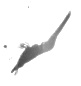

In [18]:
img = PIL.Image.open(fn) ; img

In [19]:
img.size

(81, 86)

We will plot the distribution of size of the images to choose our model size. 

In [ ]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz,col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)
plt.hist(row_sz)

Zooming!

In [ ]:
plt.hist(row_sz[row_sz<150])

We can see most images are around 50 pixels. 

## Creating and training the model

We will use a pre-trained model : resnet34.

In [6]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [14]:
arch=resnet34
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=label_csv, test_name='testFinal'
                                    ,val_idxs=val_idxs, tfms=tfms)
                                    

In [15]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=label_csv, test_name='testFinal',
                                    val_idxs=val_idxs, tfms=tfms)
    return data if sz>150 else data.resize(120, 'tmp')

In [16]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

### Let's have a quick look at the data

In [21]:
fn = PATH+data.trn_ds.fnames[0] ; fn

'data/plankton/train/100009.jpg'

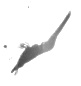

In [22]:
img = PIL.Image.open(fn) ; img

In [23]:
img.size

(81, 86)

We will plot the distribution of size of the images to choose our model size. 

In [ ]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz,col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([16156.,  4513.,  1707.,   835.,   512.,   302.,   135.,    52.,    33.,    24.]),
 array([ 31. ,  70.3, 109.6, 148.9, 188.2, 227.5, 266.8, 306.1, 345.4, 384.7, 424. ]),
 <a list of 10 Patch objects>)

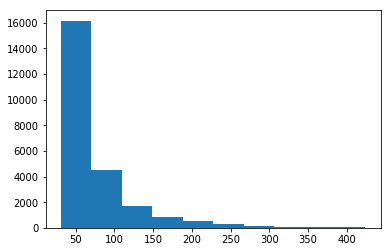

In [28]:
plt.hist(row_sz)

Zooming!

(array([5266., 6479., 3589., 2221., 1401., 1141.,  837.,  629.,  499.,  338.]),
 array([ 31. ,  42.8,  54.6,  66.4,  78.2,  90. , 101.8, 113.6, 125.4, 137.2, 149. ]),
 <a list of 10 Patch objects>)

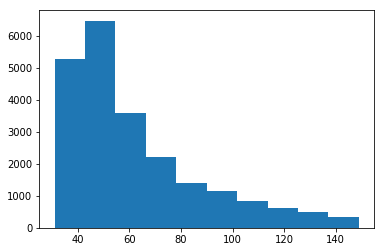

In [29]:
plt.hist(row_sz[row_sz<150])

We can see most images are around 50 pixels. 

### Back to the model

In [37]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

Find learning rate with lr_find. 

In [31]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 315/380 [00:06<00:01, 48.37it/s, loss=13.1]


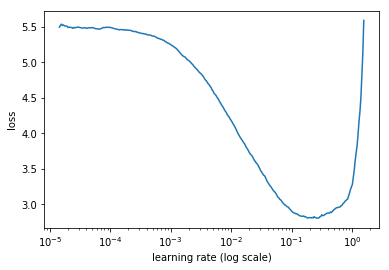

In [32]:
learn.sched.plot()

In [38]:
learn.fit(0.04, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.770982   1.426305   0.597352  
    1      1.564238   1.336263   0.614751                   
    2      1.413729   1.290255   0.631073                   
    3      1.3367     1.250024   0.633788                   
    4      1.320087   1.220008   0.642712                   



[1.2200084, 0.6427115584674634]

In [39]:
learn.precompute=False

In [40]:
learn.fit(0.04, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.537931   1.230724   0.645424  
    1      1.514323   1.23252    0.647481                   
    2      1.495521   1.225967   0.64822                    



[1.2259674, 0.6482198144260206]

In [41]:
learn.save('plank1pre')
#learn.load('plank1pre')

Unfreeze to train all the layers as our plankton images are quite far from classic imagenet pictures. 

In [42]:
learn.unfreeze()

In [43]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 333/380 [00:58<00:08,  5.69it/s, loss=9.31]

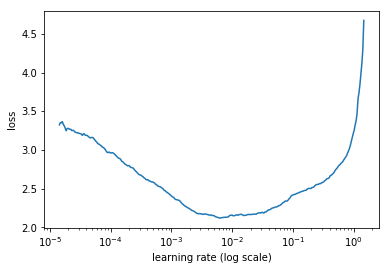

In [44]:
learn.sched.plot()

In [45]:
a = 1e-3
lr=np.array([a/9,a/3,a])

In [47]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.595575   1.302303   0.624739  
    1      1.448127   1.20861    0.645917                   
    2      1.394282   1.180435   0.652948                   
    3      1.391019   1.146453   0.662406                   
    4      1.331343   1.105643   0.671904                   
    5      1.274666   1.094445   0.676758                   
    6      1.282625   1.097249   0.677335                   
    7      1.262766   1.067113   0.684159                   
    8      1.197989   1.051591   0.687655                   
    9      1.218074   1.025622   0.695014                   
    10     1.161851   1.026663   0.694192                   
    11     1.201443   1.008276   0.697975                   
    12     1.131801   0.998984   0.702499                   
    13     1.184684   0.99337    0.70258                    
    14     1.121203   0.994035   0.704596                   



[0.9940346, 0.7045955883829217]

In [50]:
learn.save('plank2pre')
#learn.load('plank2pre')

In [55]:
log_preds = learn.predict(True)
probs = np.exp(log_preds)
probs.shape

(130400, 121)

In [56]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [60]:
df.insert(0, 'image', [o[10:] for o in data.test_ds.fnames])

In [62]:
df.to_csv(f'{PATH}subm.csv', index=False)

In [64]:
#FileLink(f'{PATH}subm.csv')

It looks like we are all set! Feel free to comment and contribute, it is highly appreciated!